In [38]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os 
import pandas as pd
from matplotlib.lines import Line2D

In [39]:
print(os.listdir(os.path.join(os.getcwd(),"ExperimentLogs")))

['2024-09-27-16-29-16', '2024-10-01-14-11-46', '2024-10-02-13-20-18', 'A', 'B', 'C_Prelim', 'debug', 'Finalissima', 'info.txt', 'Z']


In [40]:
last_exp = r"C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\Finalissima"

In [41]:
def load_all_pickles(directory:str, model: str, graphtype: str) -> list:
    """
    Iterates over all pickle files in the specified directory and loads them.
    
    :param directory: Path to the directory containing the pickle files
    :return: A list of loaded objects from the pickle files
    """
    loaded_objects = []
    final_path = os.path.join(directory, model, graphtype)
    
    for filename in os.listdir(final_path):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
    
    return loaded_objects
 

## Store the results of all Model/Scenario Combinations 

In [42]:
# Graphtype must match with the names specified in config.py 
gcn_perfect = load_all_pickles(last_exp, "GCN", "perfect")
gat_perfect = load_all_pickles(last_exp, "GAT", "perfect")
sage_perfect = load_all_pickles(last_exp, "SAGE", "perfect")
#XG_perfect = load_all_pickles(last_exp, "XGBOOST", "perfect")
XG_perfect = load_all_pickles(last_exp, "MLP", "perfect")

gcn_com = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant")
gat_com = load_all_pickles(last_exp, "GAT", "community_relevant")
sage_com = load_all_pickles(last_exp, "SAGE", "community_relevant")
#XG_com = load_all_pickles(last_exp, "XGBOOST", "community_relevant")
XG_com = load_all_pickles(last_exp, "MLP", "community_relevant")


gcn_com_h = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_heterophilic")
gat_com_h = load_all_pickles(last_exp, "GAT", "community_relevant_heterophilic")
sage_com_h = load_all_pickles(last_exp, "SAGE", "community_relevant_heterophilic")
#XG_com_h = load_all_pickles(last_exp, "XGBOOST", "community_relevant_heterophilic")
XG_com_h = load_all_pickles(last_exp, "MLP", "community_relevant_heterophilic")

# gcn_com_r = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_random")
# gat_com_r = load_all_pickles(last_exp, "GAT", "community_relevant_random")
# sage_com_r = load_all_pickles(last_exp, "SAGE", "community_relevant_random")
# XG_com_r = load_all_pickles(last_exp, "XGBOOST", "community_relevant_random")

#gcn_com_r = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_sparse")
#gat_com_r = load_all_pickles(last_exp, "GAT", "community_relevant_sparse")
#sage_com_r = load_all_pickles(last_exp, "SAGE", "community_relevant_sparse")
#XG_com_r = load_all_pickles(last_exp, "XGBOOST", "community_relevant_sparse")
#XG_com_r = load_all_pickles(last_exp, "MLP", "community_relevant_sparse")

gcn_feat = load_all_pickles(directory=last_exp,model="GCN",graphtype="cluster_relevant")
gat_feat = load_all_pickles(last_exp, "GAT", "cluster_relevant")
sage_feat = load_all_pickles(last_exp, "SAGE", "cluster_relevant")
#XG_feat = load_all_pickles(last_exp, "XGBOOST", "cluster_relevant")
XG_feat = load_all_pickles(last_exp, "MLP", "cluster_relevant")

gcn_feat_p = load_all_pickles(directory=last_exp,model="GCN",graphtype="non_seperated_cluster_relevant")
gat_feat_p = load_all_pickles(last_exp, "GAT", "non_seperated_cluster_relevant")
sage_feat_p = load_all_pickles(last_exp, "SAGE", "non_seperated_cluster_relevant")
#XG_feat_p = load_all_pickles(last_exp, "XGBOOST", "non_seperated_cluster_relevant")
XG_feat_p = load_all_pickles(last_exp, "MLP", "non_seperated_cluster_relevant")

gcn_noise = load_all_pickles(directory=last_exp,model="GCN",graphtype="noise")
gat_noise = load_all_pickles(last_exp, "GAT", "noise")
sage_noise = load_all_pickles(last_exp, "SAGE", "noise")
#XG_noise = load_all_pickles(last_exp, "XGBOOST", "noise")
XG_noise = load_all_pickles(last_exp, "MLP", "noise")


In [57]:
package = np.array([[gcn_perfect, gcn_com, gcn_com_h,
                     #gcn_com_r,
                     gcn_feat, gcn_feat_p, gcn_noise],  
                    [gat_perfect, gat_com, gat_com_h, 
                     #gat_com_r,
                     gat_feat, gat_feat_p, gat_noise],  
                    [sage_perfect, sage_com, sage_com_h,
                     #sage_com_r,
                     sage_feat, sage_feat_p, sage_noise],  
                    [XG_perfect, XG_com, XG_com_h,
                     #XG_com_r,
                     XG_feat, XG_feat_p, XG_noise]])

n_scenarios = package.shape[1]
print(n_scenarios)

colors = ["forestgreen", "royalblue", "mediumslateblue", "darkorange", "goldenrod", "firebrick"]
#colors = ["forestgreen", "royalblue", "dodgerblue", "mediumslateblue", "orange", "goldenrod", "firebrick"]


6


# Plot 

In [58]:
def plot_with_confidence_interval(target, color, key="loss_track", empirical_CI=True, ax=None, percentiles=5):
    """
    Plots figure for one Scenario in specified axis.
    :param target: Results of the scenario.
    :param color: Color for scenario mapping.
    :param key: Key to extract values from target.
    :param empirical_CI: Boolean to use empirical confidence interval.
    :param ax: Axis object to plot on.
    :return: None
    """
    ys = np.array([lp[key] for lp in target])  # loss-values @ epoch
    final_epoch = np.mean([lp["final_epoch"] for lp in target])

    mean_ys = np.mean(ys, axis=0)
    std_ys = np.sqrt(np.var(ys, axis=0))

    if empirical_CI:
        ci_lower = np.percentile(ys, percentiles, axis=0)
        ci_upper = np.percentile(ys, (100-percentiles), axis=0)
    else:
        ci_upper = mean_ys + 1.96 * std_ys
        ci_lower = mean_ys - 1.96 * std_ys

    x = np.arange(len(mean_ys))

    ax.plot(x, mean_ys, color=color)
    ax.fill_between(x, ci_lower, ci_upper, color=color, alpha=0.2)
    ax.axvline(x=final_epoch, color=color, linestyle='--')
    
    return final_epoch

### Loss Curves

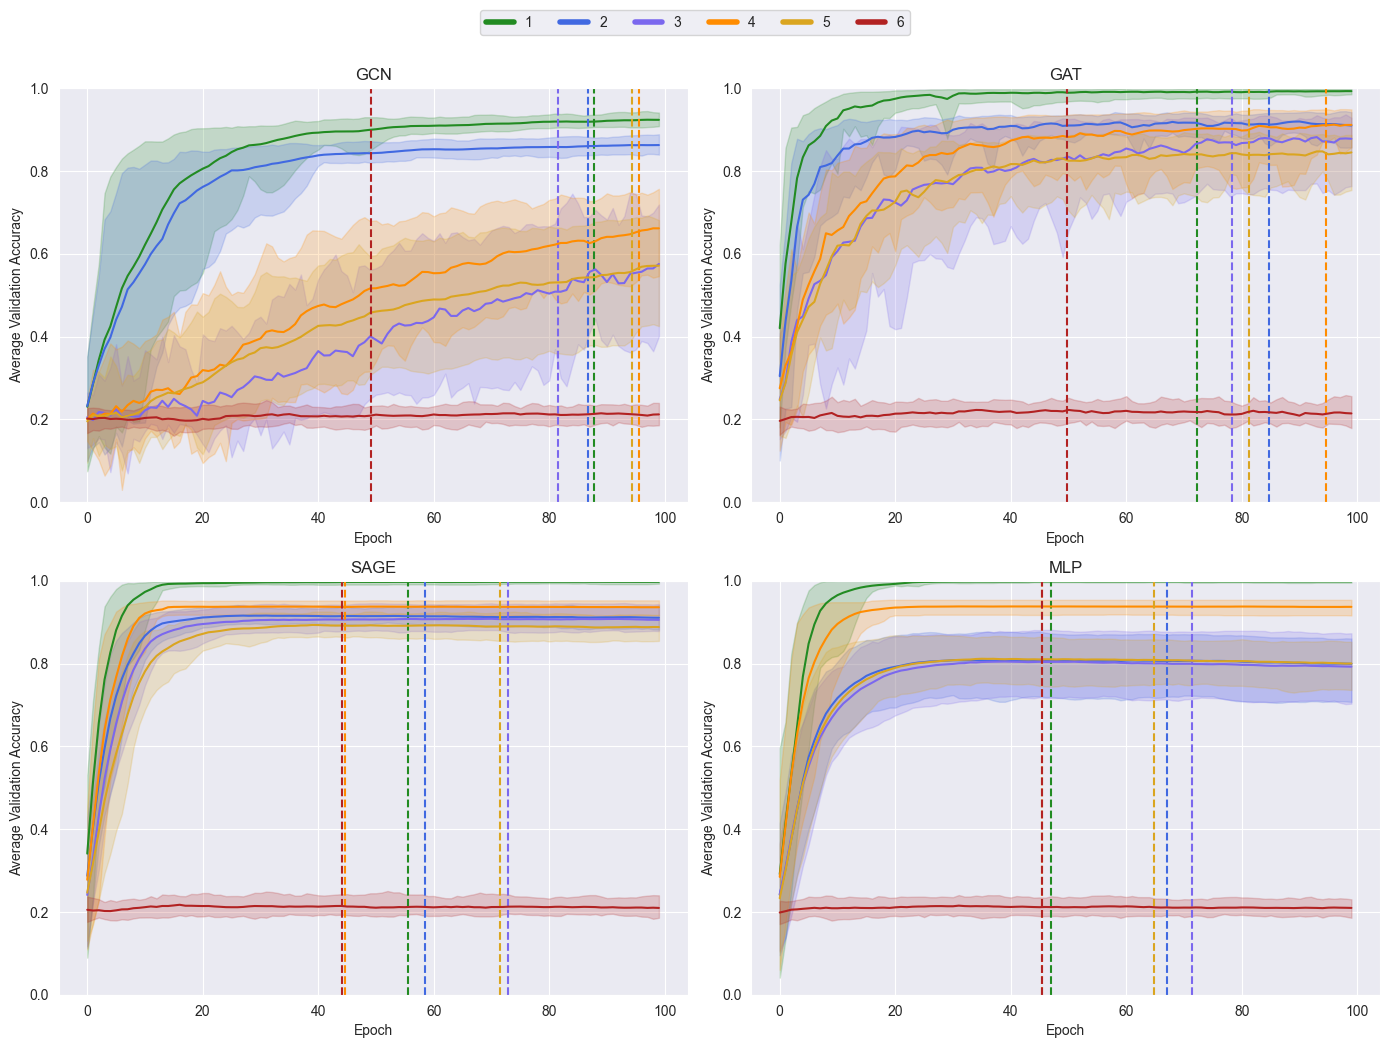

array([[87.77, 86.67, 81.53, 95.6 , 94.27, 49.1 ],
       [72.23, 84.7 , 78.33, 94.63, 81.2 , 49.77],
       [55.53, 58.57, 72.9 , 44.57, 71.43, 44.1 ],
       [46.97, 67.03, 71.4 , 45.5 , 64.83, 45.37]])

In [64]:
#l_o_a = "loss_track"  
l_o_a = "val_acc_track"

arch = ["GCN", "GAT", "SAGE", "MLP"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

early_stops = np.zeros((4, n_scenarios))

labels = np.arange(n_scenarios) + 1


for i, (model, ax) in enumerate(zip(package, axes)):
    for j, (target, label, color) in enumerate(zip(model, labels, colors)):
        early_stops[i, j] = plot_with_confidence_interval(target, color, key=l_o_a,
                                                          empirical_CI=True, ax=ax, percentiles=5)
        ax.plot([], [], color=color, label=label)  # Adding to legend

    ax.set_xlabel('Epoch')
    if l_o_a == "loss_track":
        ax.set_ylabel('Average Loss')
    else:
        ax.set_ylabel('Average Validation Accuracy')
        
    ax.set_ylim(0, 1)
    ax.set_title(f'{arch[i]}')

handles = [Line2D([0], [0], color=color, lw=4) for color in colors]  # Farben unterscheiden 
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')

plt.tight_layout()
plt.show()
np.round(early_stops, 2)

#  GCN könnte mehr epochs vertragen !!
# Erwartungswert von random guess (Wahrscheinlichkeit) 600/3000
# Zeit pro Epoche -> Zeitvergleich 
# 

In [17]:
# Loss/val_acc tracks appear very similar for com_random across all 4 models
# np.mean([r["test_accuracy"] for r in gat_com_r], axis=0) == np.mean([r["test_accuracy"] for r in sage_com_r], axis=0)
print(np.round(np.mean([r["test_accuracy"] for r in gcn_perfect]), 3))
print(np.round(np.mean([r["test_accuracy"] for r in sage_com]),3))

0.919
0.928


### Test accs 

In [62]:
mus = np.zeros((4, n_scenarios))  # models (i) x scenarios (j)
sigs = np.zeros((4, n_scenarios))  

for i, model in enumerate(package): #[[GCN,...], [GAT,...],...]
    for j, scen in enumerate(model): # [1, 2, 3, 4, 5, 6, 7]
        accs = [acc["test_accuracy"] for acc in scen]
        
        mus[i, j] += np.round(np.mean(accs), 3)
        sigs[i, j] += np.round(np.sqrt(np.var(accs)), 3)


result = np.array([[f'{a} ({b})' for a, b in zip(row_A, row_B)]
                   for row_A, row_B in zip(mus, sigs)])        

result = pd.DataFrame(result,
                      index=["GCN", "GAT","SAGE","MLP"],
                      columns=["Perfect", "com", "com_h",
                               #"com_sparse",
                               "feat", "feat_p", "noise"])
result


,Perfect,com,com_h,feat,feat_p,noise
GCN,0.916 (0.014),0.855 (0.019),0.51 (0.179),0.643 (0.1),0.557 (0.113),0.212 (0.023)
GAT,0.991 (0.008),0.912 (0.031),0.868 (0.064),0.905 (0.048),0.844 (0.044),0.217 (0.02)
SAGE,0.998 (0.003),0.915 (0.015),0.908 (0.023),0.938 (0.014),0.896 (0.019),0.219 (0.021)
MLP,0.999 (0.001),0.807 (0.052),0.804 (0.041),0.938 (0.014),0.808 (0.04),0.216 (0.023)


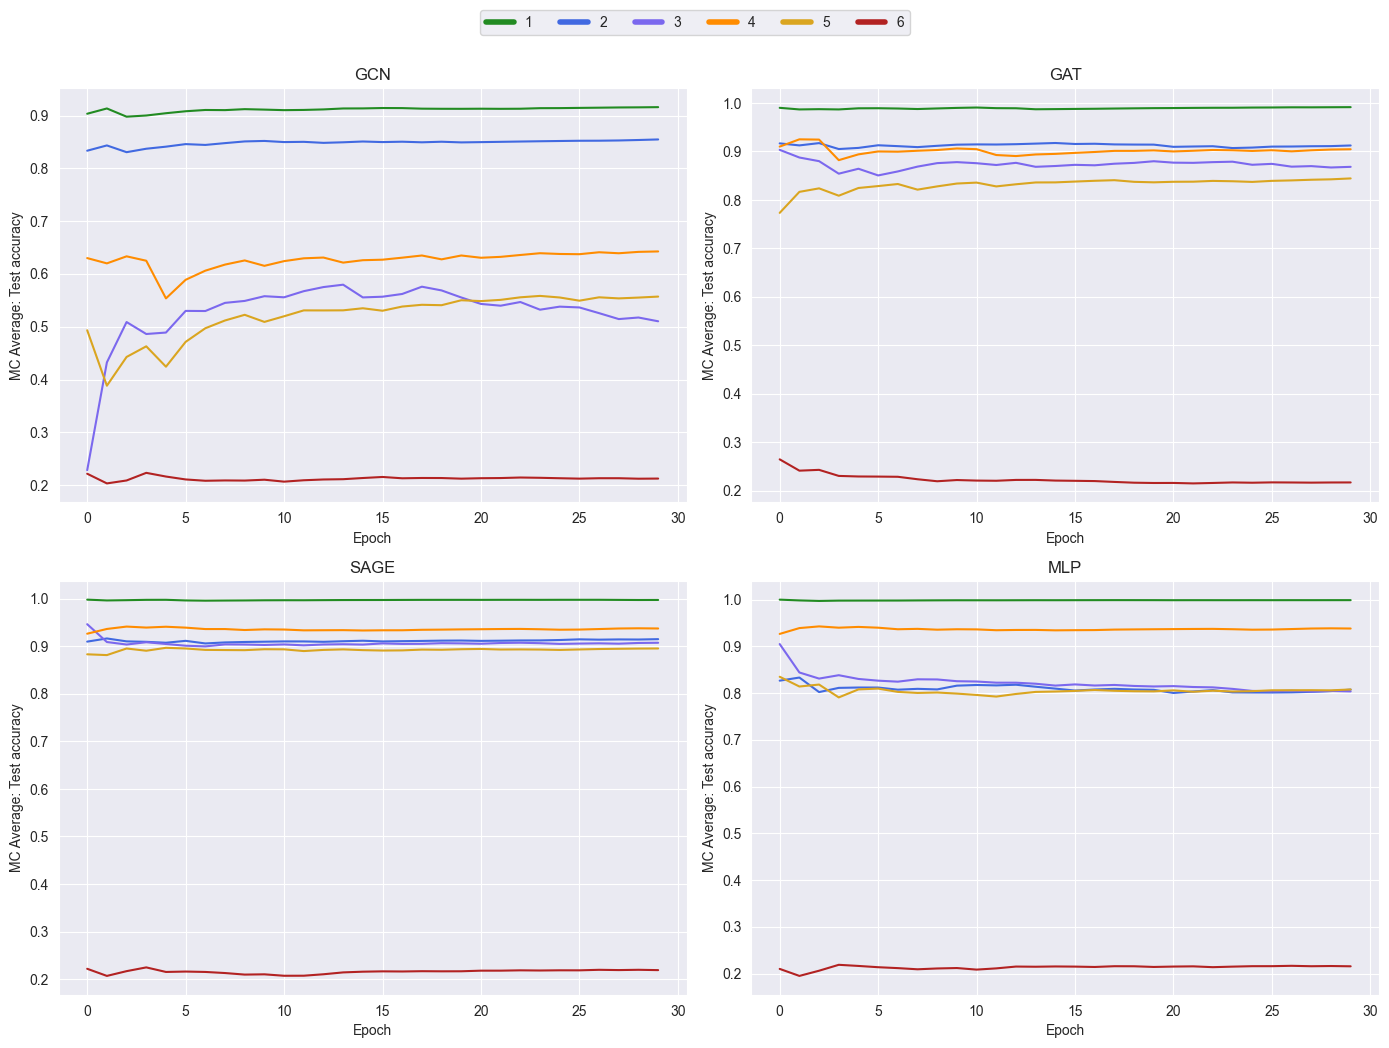

In [49]:
def MCR_plot(target, color, ax=None):
        ys = [lp["test_accuracy"] for lp in target] 
        r_avg = np.cumsum(ys) / np.arange(1, len(ys) + 1)
        x = np.arange(len(ys))
        ax.plot(x, r_avg, color=color)

arch = ["GCN", "GAT", "SAGE", "MLP"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

labels = np.arange(n_scenarios) + 1
colors = ["forestgreen", "royalblue", "mediumslateblue", "darkorange", "goldenrod", "firebrick"]


for i, (model, ax) in enumerate(zip(package, axes)):
    for j, (target, label, color) in enumerate(zip(model, labels, colors)):
        early_stops[i, j] = MCR_plot(target, color, ax=ax)
        ax.plot([], [], color=color, label=label) 

    ax.set_xlabel('MC-Iteration')
    ax.set_ylabel('MC Average: Test accuracy')
    
    ax.set_title(f'{arch[i]}')

handles = [Line2D([0], [0], color=color, lw=4) for color in colors]
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')

plt.tight_layout()
plt.show()


# Graph Characteristics 

In [50]:
def load_all_pickles_char(directory:str, graphtype: str) -> list:
    """
    Iterates over all pickle files in the specified directory and loads them.
    
    :param directory: Path to the directory containing the pickle files
    :return: A list of loaded objects from the pickle files
    """
    loaded_objects = []
    final_path = os.path.join(directory, "GraphCharacteristics", graphtype)
    
    # Iterate over all files in the directory
    for filename in os.listdir(final_path):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
    
    return loaded_objects
 

In [51]:
perfect = load_all_pickles_char(directory=last_exp,graphtype="perfect")
community_relevant = load_all_pickles_char(directory=last_exp,graphtype="community_relevant")
community_relevant_h = load_all_pickles_char(directory=last_exp,graphtype="community_relevant_heterophilic")
#community_relevant_r = load_all_pickles_char(directory=last_exp,graphtype="community_relevant_sparse")
cluster_relevant = load_all_pickles_char(directory=last_exp,graphtype="cluster_relevant")
cluster_relevant_p = load_all_pickles_char(directory=last_exp,graphtype="non_seperated_cluster_relevant")
noise = load_all_pickles_char(directory=last_exp,graphtype="noise")

package2 = np.array(([perfect, community_relevant, community_relevant_h,
            #community_relevant_r,
            cluster_relevant, cluster_relevant_p, noise]))

n_scenarios = package2.shape[0]
n_scenarios

6

In [81]:
x = np.random.normal(0,1,30)
upper_lower = lambda x, p : (np.percentile(x, p, axis=0), np.percentile(x, (100-p), axis=0))
np.round(upper_lower(x, 2.5),2)

array([-1.81,  1.74])

In [103]:
mus = np.zeros((2, n_scenarios))  
sigs = np.empty((2, n_scenarios), dtype="U64")  
upper_lower = lambda x, p : str(np.round((np.percentile(x, p, axis=0), np.percentile(x, 100-p, axis=0)), 3))

for k, m in enumerate(["h_hat", "wilks_lambda"]):
    for i, s in enumerate(package2): 
        y = [acc[m] for j, acc in enumerate(s)]
        accuracy = np.mean(y)
        # sd_accuracy = np.var(y)
        mus[k, i] += np.round(accuracy, 3)
        # sigs[k, i] += np.round(np.sqrt(sd_accuracy), 3)
        sigs[k, i] = upper_lower(y, 5)
    
    
    # result = np.array([[f'{a} ({b})' for a, b in zip(row_A, row_B)] for row_A, row_B in zip(mus, sigs)])        
    result = mus
    result = pd.DataFrame(result,
                          index=["h", "L"],
                          columns=["Perfect", "com", "com_h" ,
                                   #"com_r",
                                   "feat", "feat_p", "noise"])

result
# 1 - L: für bessere Interpretierbarkeit 
# Standardabweichungen vielleicht durch quantile ersetzen 
# 0.037 (0.044) Pronlematisch 

,Perfect,com,com_h,feat,feat_p,noise
h,0.686,0.592,0.000,0.001,0.001,0.000
L,0.037,0.238,0.267,0.102,0.239,0.516


In [53]:
Y = np.zeros((4,n_scenarios,30))
rs = Y.shape[1] * Y.shape[2]

for i, model in enumerate(package): #[[GCN,...], [GAT,...],...]
    for j, scen in enumerate(model): # [1, 2, 3, 4, 5, 6, 7]
        accs = [acc["test_accuracy"] for acc in scen]
        Y[i,j,:] = accs
        
x1 = np.array(([g["h_hat"] for g in perfect],
          [g["h_hat"] for g in community_relevant],
          [g["h_hat"] for g in community_relevant_h],
          #[g["h_hat"] for g in community_relevant_r],
          [g["h_hat"] for g in cluster_relevant],
          [g["h_hat"] for g in cluster_relevant_p],
          [g["h_hat"] for g in noise])).flatten().reshape(rs)

x2 = np.array(([g["wilks_lambda"][0] for g in perfect],
          [g["wilks_lambda"][0] for g in community_relevant],
          [g["wilks_lambda"][0] for g in community_relevant_h],
          #[g["wilks_lambda"][0] for g in community_relevant_r],
          [g["wilks_lambda"][0] for g in cluster_relevant],
          [g["wilks_lambda"][0] for g in cluster_relevant_p],
          [g["wilks_lambda"][0] for g in noise])).flatten().reshape(rs)

In [54]:
Y.shape

(4, 6, 30)

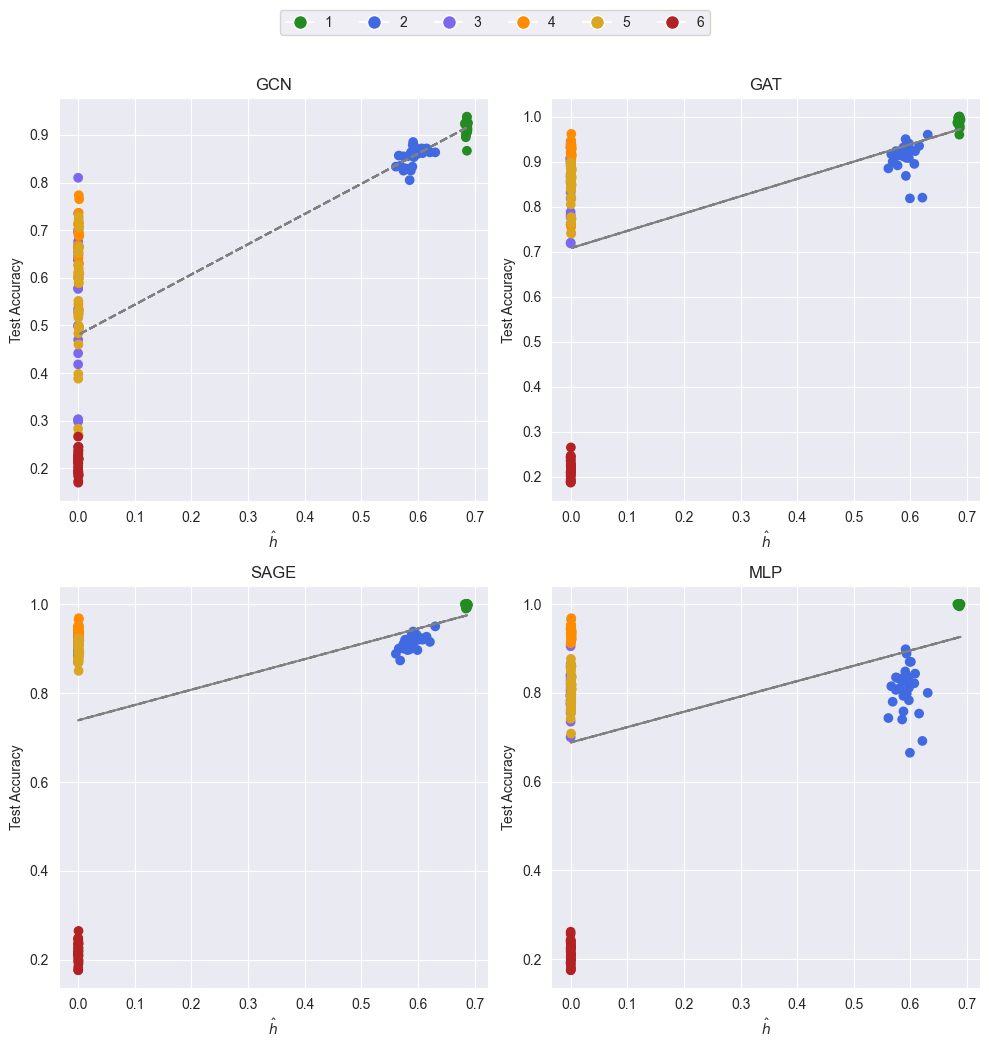

In [55]:
def plot_scatter_relation(X, y, colors, xlab):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    model_names = ["GCN", "GAT", "SAGE", "MLP"]

    color_labels = np.arange(1, len(colors) + 1)

    for i, ax in enumerate(axs.flatten()):

        repeated_colors = np.repeat(colors, 30)
        sc = ax.scatter(X, y[i, :, :].flatten(), color=repeated_colors)
        
        coef = np.polyfit(X, y[i, :, :].flatten(), 1)  
        poly1d_fn = np.poly1d(coef)
        ax.plot(X, poly1d_fn(X), '--', color='grey')  

        # Set title for each subplot
        ax.set_title(model_names[i])
        ax.set_xlabel(xlab)  
        ax.set_ylabel('Test Accuracy')  

    # Add a shared legend with numeric range
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(label),
                           markerfacecolor=color, markersize=10) 
               for label, color in zip(color_labels, colors)]
    
    fig.legend(handles=handles, loc='upper center', ncol=len(color_labels), bbox_to_anchor=(0.5, 1.05))
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])  # Adjust layout to make room for the legend
    plt.show()

plot_scatter_relation(x1, Y, colors, r"$\hat{h}$")

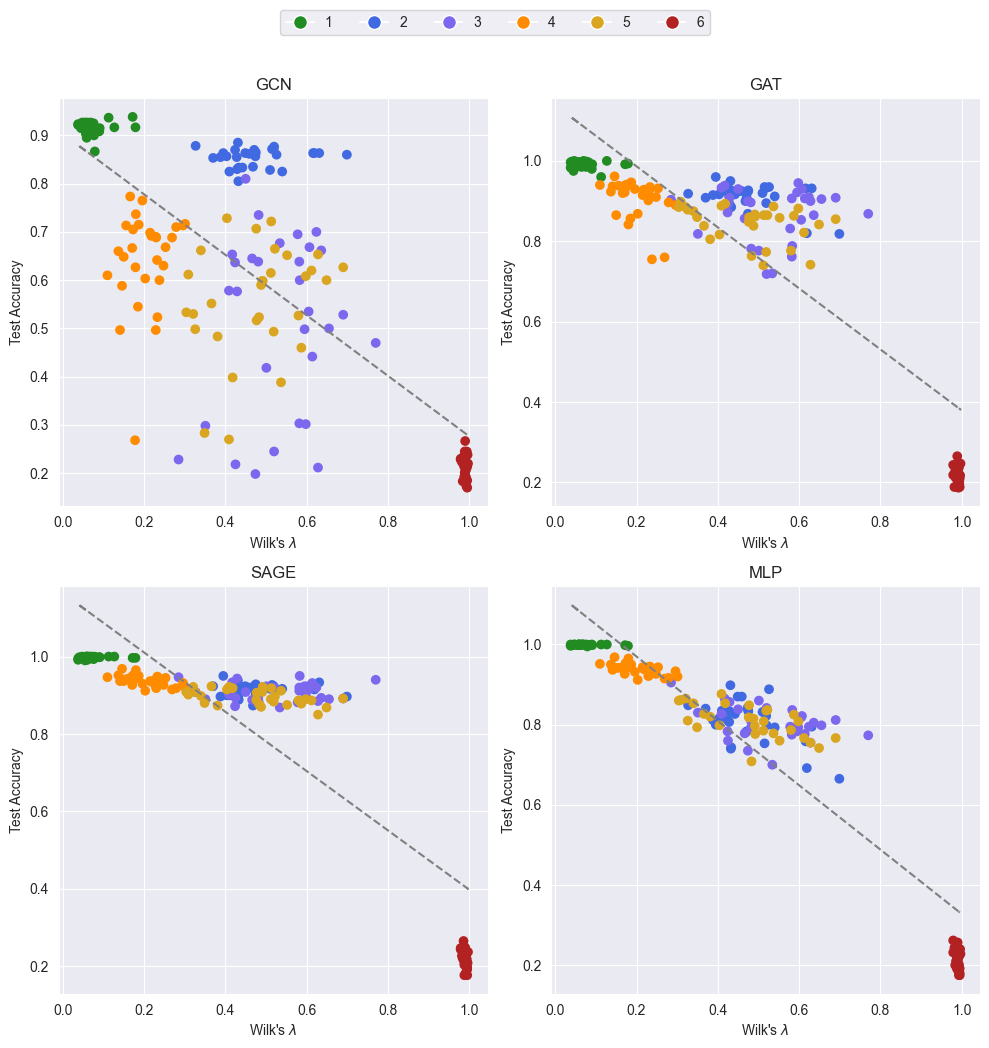

In [56]:
plot_scatter_relation(x2, Y, colors, r"Wilk's $\lambda$")
# Muss alles von 0 - 1 laufen (y-axe) 

In [ ]:
# fig, axes = plt.subplots(2, 1, figsize=(10, 8))
# 
# for idx, m in enumerate(["h_hat", "wilks_lambda"]):
#     cumavg = lambda x: np.cumsum(x) / np.arange(1, len(x) + 1)
#     M = np.array([[lp[m] for lp in scen] for scen in package2])
#     M = np.apply_along_axis(cumavg, 1, M)  
# 
#     for i in range(M.shape[0]):
#         axes[idx].plot(np.arange(M.shape[1]), M[i], color=colors[i]) # x, y, col
# 
#     axes[idx].set_title(f'Cumulative Average of {m}')
#     axes[idx].set_xlabel('Time')
#     axes[idx].set_ylabel(f'{m} values')
# 
# 
# lines = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(n_scenarios)]
# fig.legend(lines, [f'{label}' for label in labels], loc='upper center', ncol=n_scenarios)
# 
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend at the top
# 
# # Show the plots
# plt.show()